In [5]:
from diffusion.heston_process import simulate_heston
from pricing.option_heston import option_heston
from pricing.option_bsm import option_european_bsm
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd
mpl.rc("savefig", dpi=200)
%config InlineBackend.figure_format = 'svg'

In [6]:
initialValue = 100
mu = 0.01
sigma = 0.2
process = ql.GeometricBrownianMotionProcess(initialValue, mu, sigma)

In [16]:
%config IPCompleter.greedy = True
from QuantLib import *
import numpy as Numpy
import matplotlib.pyplot as Matplotlib

# process = QuantLib 1-dimensional stochastic process object
def GeneratePaths(process, maturity, nPaths, nSteps):
    generator = UniformRandomGenerator()
    sequenceGenerator = UniformRandomSequenceGenerator(nSteps, generator)
    gaussianSequenceGenerator = GaussianRandomSequenceGenerator(sequenceGenerator)
    paths = Numpy.zeros(shape = ((nPaths), nSteps + 1))
    pathGenerator = GaussianPathGenerator(process, maturity, nSteps, gaussianSequenceGenerator, False)
    for i in range(nPaths):
        path = pathGenerator.next().value()
        paths[i, :] = Numpy.array([path[j] for j in range(nSteps + 1)])
    return paths


# general parameters and objects
tradeDate = Date(23, November, 2018)
Settings_instance().evaluationDate = tradeDate
dayCounter = Actual360()
calendar = UnitedStates()
settlementDate = calendar.advance(tradeDate, 2, Days)

# common simulation-related parameters for all processes
maturity = 3.0
nPaths = 50
nSteps = int(maturity * 365)
timeGrid = Numpy.linspace(0.0, maturity, nSteps + 1)

# create HW1F model, request paths from generator
reversionSpeed = 0.05
rateVolatility = 0.0099255
r = QuoteHandle(SimpleQuote(0.01))
curve = RelinkableYieldTermStructureHandle(FlatForward(settlementDate, r, dayCounter))
HW1F = HullWhiteProcess(curve, reversionSpeed, rateVolatility)
hw1f_paths = GeneratePaths(HW1F, maturity, nPaths, nSteps)

# create GBM model, request paths from generator
initialValue = 0.01
mue = 0.01
sigma = 0.0099255
GBM = GeometricBrownianMotionProcess(initialValue, mue, sigma)
gbm_paths = GeneratePaths(GBM, maturity, nPaths, nSteps)

# plot all paths for the both processes
f, subPlots = Matplotlib.subplots(2, sharex = True)
Matplotlib.rcParams['figure.figsize'] = [16.0, 10.0]
f.suptitle('Path simulations n=' + str(nPaths))
subPlots[0].set_title('Hull-White 1-Factor')
subPlots[1].set_title('Geometric Brownian Motion')

for i in range(hw1f_paths.shape[0]):
    path = hw1f_paths[i, :] 
    subPlots[0].plot(timeGrid, path)

for i in range(gbm_paths.shape[0]):
    path = gbm_paths[i, :] 
    subPlots[1].plot(timeGrid, path)

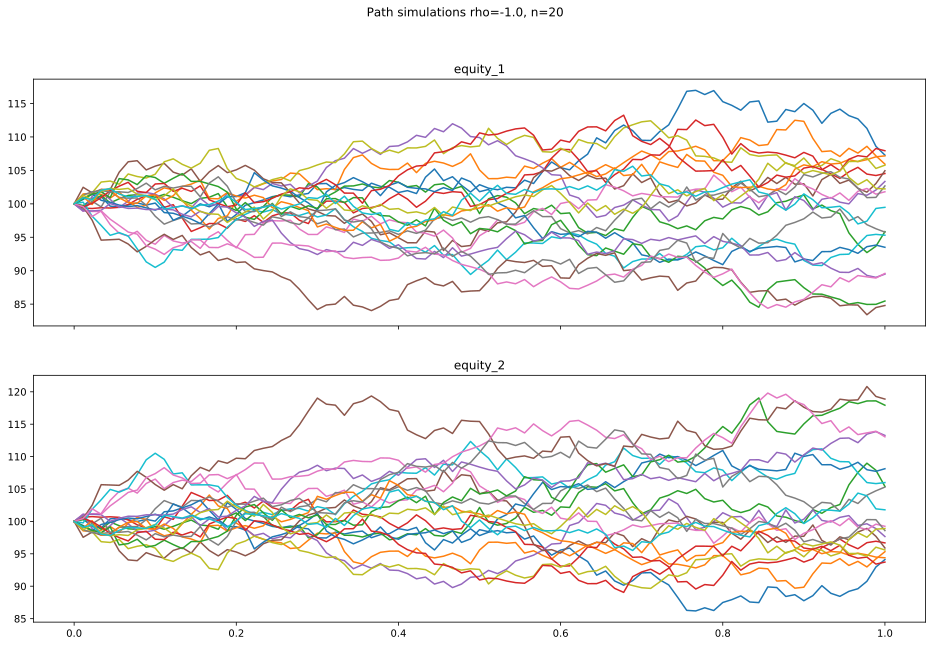

In [17]:
%config IPCompleter.greedy = True
from QuantLib import *
import numpy as Numpy
import matplotlib.pyplot as Matplotlib

# processArray = StochasticProcessArray (Array of correlated 1-D stochastic processes)
# timeGrid = TimeGrid object
def GenerateCorrelatedPaths(processArray, timeGrid, nPaths):
    times = []; [times.append(timeGrid[t]) for t in range(len(timeGrid))]
    generator = UniformRandomGenerator()
    nProcesses = processArray.size()
    nGridSteps = len(times) - 1 # deduct initial time (0.0)
    nSteps = nGridSteps * nProcesses
    sequenceGenerator = UniformRandomSequenceGenerator(nSteps, generator)
    gaussianSequenceGenerator = GaussianRandomSequenceGenerator(sequenceGenerator)
    multiPathGenerator = GaussianMultiPathGenerator(processArray, times, gaussianSequenceGenerator)
    paths = Numpy.zeros(shape = (nPaths, nProcesses, len(timeGrid)))

    # loop through number of paths
    for i in range(nPaths):
        # request multiPath, which contains the list of paths for each process
        multiPath = multiPathGenerator.next().value()
        # loop through number of processes
        for j in range(multiPath.assetNumber()):
            # request path, which contains the list of simulated prices for a process
            path = multiPath[j]
            # push prices to array
            paths[i, j, :] = Numpy.array([path[k] for k in range(len(path))])
    return paths

# create two 1-D stochastic processes
process = []
nProcesses = 2
correlation = -1.0
names = ['equity_1', 'equity_2']
spot = [100.0, 100.0]
mue = [0.01, 0.01]
sigma = [0.10, 0.10]
[process.append(GeometricBrownianMotionProcess(spot[i], mue[i], sigma[i])) for i in range(nProcesses)]
matrix = [[1.0, correlation], [correlation, 1.0]]

# create timegrid object and define number of paths
maturity = 1.0
nSteps = 90
timeGrid = TimeGrid(maturity, nSteps)
nPaths = 20

# create StochasticProcessArray object
# (array of correlated 1-D stochastic processes)
processArray = StochasticProcessArray(process, matrix)
# request simulated correlated paths for all processes
# result array dimensions: nPaths, nProcesses, len(timeGrid)
paths = GenerateCorrelatedPaths(processArray, timeGrid, nPaths)

# plot paths
f, subPlots = Matplotlib.subplots(nProcesses, sharex = True)
f.suptitle('Path simulations rho=' + str(correlation) + ', n=' + str(nPaths))

for i in range(nPaths):
    for j in range(nProcesses):
        subPlots[j].set_title(names[j])
        path = paths[i, j, :]
        subPlots[j].plot(timeGrid, path)